# Comparing Hypergraph Embeddings

The goal of this notebook is to use the tools in the [Tutte Institute ``vectorizers`` library](https://github.com/TutteInstitute/vectorizers) to construct document embeddings, and to compare those document embeddings with results from other popular techniques. We will compare embeddings obtained by the following techniques:
* TF-IDF (sklearn)
* Information Weighted Embedding (vectorizers library)
* Wasserstein Embedding (vectorizers library)
* Approximate Wasserstein Embedding (vectorizers library)

We will compare these techniques qualitatively using the advanced eyeball test (via dimension reduction using UMAP) as well as by quantitatively using a downstream classification task.

At this point ``vectorizers`` is still a research project, so this is not meant to be a rigorous comparison but rather a demonstration of general relative performance, and to show off the potential for non-neural net based approaches.

### Setup

In [1]:
# from src import paths
# from src.data import Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import warnings
      
warnings.simplefilter("ignore")
sns.set()

We will need some data to work with. For the purposes of this demo we will make use of the 20 newsgroups dataset. Even though 20 newsgroups is a toy dataset, it offers enough complications to show how we can piece together document embeddings using ``vectorizers``. We've cleaned it up a little and created a custom color paletted as in `00-20-newsgroups-setup.ipynb`.

In [3]:
execfile('./00-data-setup.py')
recipes, recipes_label_id, ingredients_id, label_name, color_key = read_format_recipes()
recipes_label = [label_name.loc[i]['new_label'] for i in recipes_label_id.label]

# Vectorizers library

In [4]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()

CPU times: user 126 µs, sys: 0 ns, total: 126 µs
Wall time: 130 µs


In [5]:
%%time
long_list = max(len(x) for x in recipes)
ingredient_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 21.7 s, sys: 1.03 s, total: 22.7 s
Wall time: 21.6 s


These operations are relatively quick because it is matter of counting things and applying standard linear algebra techniques. This produces serviceable word vectors which are specifically trained on our corpus and cover the idiomatic usage of various words within the particular context of the 20 newsgroups dataset.

### Step 1: Bag-of-words Embedding

The next step in the process is to get a document embedding, that is, obtain document vectors. Since we will be using the word vectors that we've learned later, we will restrict our document embedding to the same vocabulary as the word vectors. 

To start with let's create a bag-of-words model. For that, we'll use the ``NgramVectorizer`` which is the vectorizer libraries "sequence of tokens" counterpart to the text specific ``CountVectorizer`` from sklearn.


In [6]:
%%time
doc_matrix = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit_transform(recipes)

CPU times: user 4.83 s, sys: 154 ms, total: 4.98 s
Wall time: 3.27 s


In [7]:
%%time
unsupervised_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(doc_matrix)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 4min 58s, sys: 6.63 s, total: 5min 4s
Wall time: 1min 8s


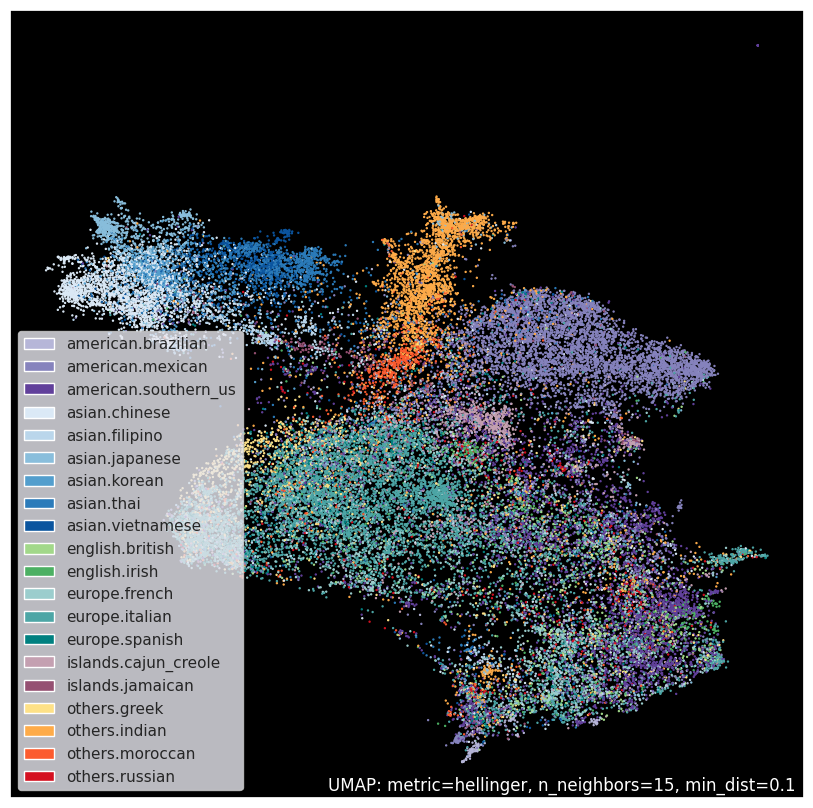

In [8]:
umap.plot.points(
    unsupervised_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("figures/no_weight_unsupervised.png", facecolor="none")

### Step 2: Information Weight Embedding

Not all words are equally informative. For example, "the" and "embedding" contain different amounts of information in a sentence. Since each feature column of our bag-of-words representation corresponds to a word, we would like to have a feature weighting scheme that can account for the different amounts of information coming from each word.

This is behind the thinking of the classic TF-IDF approach; words are weighted according to the (log of the) inverse frequency of document occurrences of the word. While this can be effective, it is a little ad-hoc. We will make this approach more explicit using of the ``InformationWeightTransformer`` from ``vectorizers``.

The ``InformationWeightTransformer`` takes an information theoretic view to generating feature weights for count data. To determine a weight for how "informative" a word is, we look at the amount of information gained by using the actual observed distribution of occurrences of the word among documents instead of a baseline distribution (the distribution of occurrences assuming the word occurred uniformly randomly in the text). We can enhance this a by making use of a Bayesian prior on the distribution (ensuring that infrequent words aren't artificially deemed to be informative).

The ``InformationWeightTransformer`` can go a step further as well. Instead of looking at information gain from distributions over documents, we can also factor in information gain from distributions over *document labels* if we happen to have label information for our documents. In this case we do have label information, the newsgroup of the document, but in many cases we may not.

To show the full range of options we'll take both approaches--an unsupervised approach which does not see any label information, and the supervised approach where we can take advantage of distributions over labels to determine feature weights.

In [9]:
%%time
unsupervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix)

supervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix, recipes_label)

CPU times: user 9.49 s, sys: 347 ms, total: 9.84 s
Wall time: 4.59 s


This is a remarkably efficient process! To see the impact of re-weighting the features on our document embedding, we'll use UMAP again.

In [10]:
%%time
unsupervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(unsupervised_info_doc_matrix)
supervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(supervised_info_doc_matrix)

CPU times: user 10min 39s, sys: 13.9 s, total: 10min 53s
Wall time: 1min 41s


First let's look at the unsupervised case, achieved only by looking at distributions over documents and with no label information whatsoever.

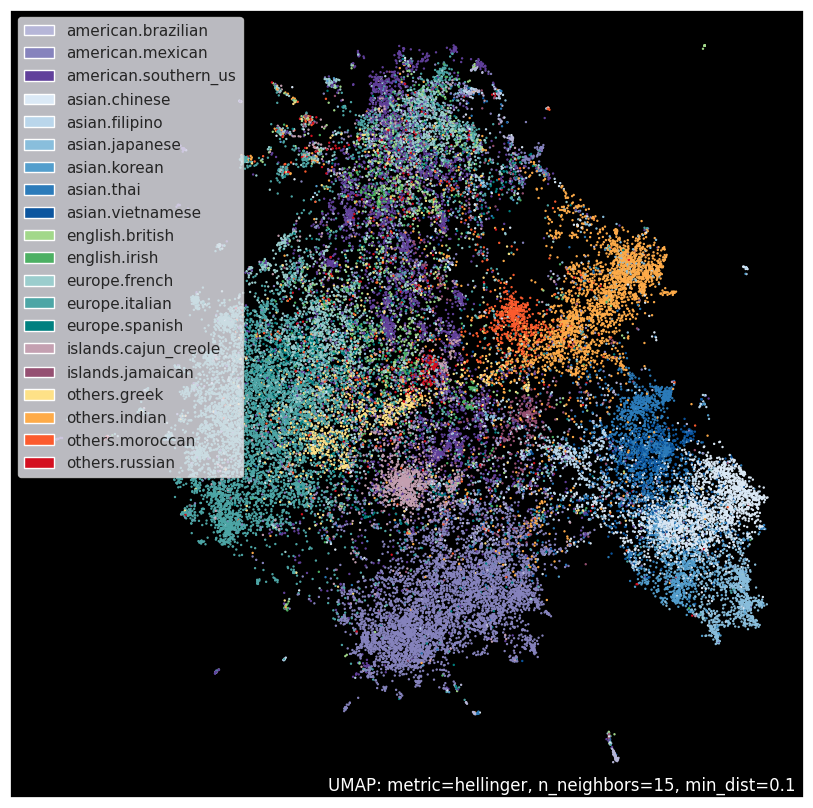

In [11]:
umap.plot.points(
    unsupervised_info_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
# plt.savefig(paths['figures_path'] / "info_weight_unsupervised.png", facecolor="none")
plt.savefig("figures/info_weight_unsupervised.png", facecolor="none")

This looks like a huge improvement over the raw bag-of-words approach and all we have done is reweight the columns. From a visual inspection this looks at least somewhat comparable to the BERT embedding. That is pretty impressive for such a simple and cheap transformation of the bag-of-words document model.

Let's see what can be achieved with the additional use of label information in deciding how to reweight columns. Keep in mind that we are not tagging rows with label information, we are scaling columns by the amount of information we deem each column to have. The label information is allowing us to upweight columns that appear to be "informative" with respect to labels.

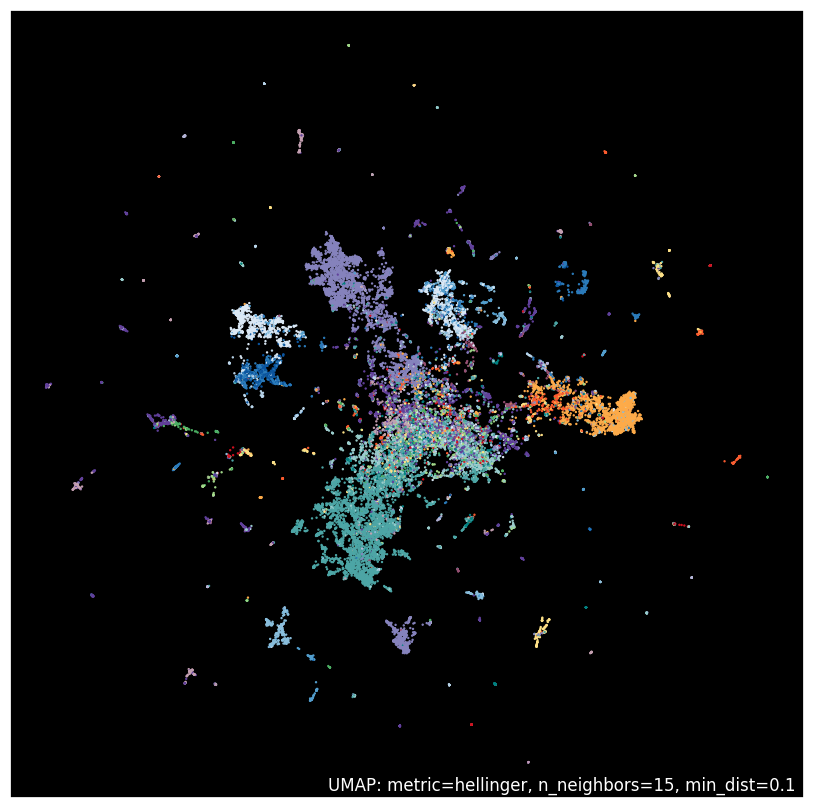

In [12]:
umap.plot.points(
    supervised_info_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
    show_legend=False,
)
plt.savefig("figures/info_weight_supervised.png", facecolor="none")

This is remarkably good! Yes, we made use of label information, but it is not that uncommon to have such some labels on hand. Notably, since we only used that information to derive feature weights, we can easily use this transformer on a training set and apply the learned weights to an unlabeled test set. 

### Step 3A: Wasserstein Embedding via Linear Algebra Approximation

It's time to start applying more sophisticated transformations. We will use the ``ApproximateWassersteinVectorizer`` which applies basic linear algebra transformations to provide heuristic approximations to a linearization of a Wasserstein metric space. Okay, that was a mouthful; let's unpack this in terms of document representation and word vectors.

The output from the Information Weighted document embedding are vectors of (weighted) counts of how often each word appears in each document. When we applied UMAP to this embedding, we used Hellinger distance where we view these vectors as defining (multinomial) distributions over our feature space of words.

This is all very well, but words are not completely independent of each other (which a multinomial distribution would assume). Some words are similar; other words are completely unrelated. In other words we have a metric space of words. And indeed we already have a metric space of words as defined by our word vectors as long as we have a suitable distance function.

Since our word vectors are computed as distributions, measuring the distance between these word vectors requires measuring distances between distributions. So then, how do we measure distances between distributions over metric spaces? Not Hellinger distance anymore, but Wasserstein distance. Unfortunately Wasserstein distance is exceedingly expensive to compute; in this case it is effectively the same as [Word Mover Distance](http://proceedings.mlr.press/v37/kusnerb15.pdf) with our custom feature weighting. We can plug Wasserstein distance into UMAP and get a 2D embedding, but it will take a hours and hours to compute.

To take a different approach, what if we could transform our data so that cosine distance in the transformed space was closely correlated with Wasserstein distance in the original space? Then applying UMAP with cosine distance on the transformed space would approximate UMAP with Wasserstein distance on the original space. 

Let's begin by trying quick and dirty transformations that only require simple linear algebra operations to do this. We will compare this to a theoretically sound approach in the next example.

We will apply basis transformations and rescalings to combine the word vectors with the document representations. The result will be document vectors with the same dimensionality as our word vectors that heuristically provide an approximation to the theory-based approaches we'll be trying next. 

The `vectorizers` library provides this functionality in the ``ApproximateWassersteinVectorizer`` which takes as input a sparse matrix where each row represents a (potentially scaled) distribution over some space, and vectors which can provide a representation of the space itself. In our case, we will take the Information Weighted document matrices we have constructed together with the word vectors (which provide a vector representation of the feature columns of the document matrices).

We will apply this transformation to both the unsupervised version of our document matrix, and the supervised version, which took label information into account when generating column reweighting. We'll try each in turn to see how the different options perform.

In [13]:
%%time
lat_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(unsupervised_info_doc_matrix, vectors=ingredient_vectors)

CPU times: user 6.55 s, sys: 1.84 s, total: 8.39 s
Wall time: 878 ms


In [14]:
%%time
lat_vectors_supervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(supervised_info_doc_matrix, vectors=ingredient_vectors)

CPU times: user 6.83 s, sys: 1.52 s, total: 8.35 s
Wall time: 772 ms


Note that this was an incredibly cheap operation to compute since it was all handled under-the-hood by simple linear algebra operations of basis change and rescaling. As usual we can UMAP the results and see what we get.

In [15]:
%%time
unsupervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_unsupervised)
supervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_supervised)

CPU times: user 2min 20s, sys: 12.9 s, total: 2min 33s
Wall time: 1min 11s


<Figure size 1600x1600 with 0 Axes>

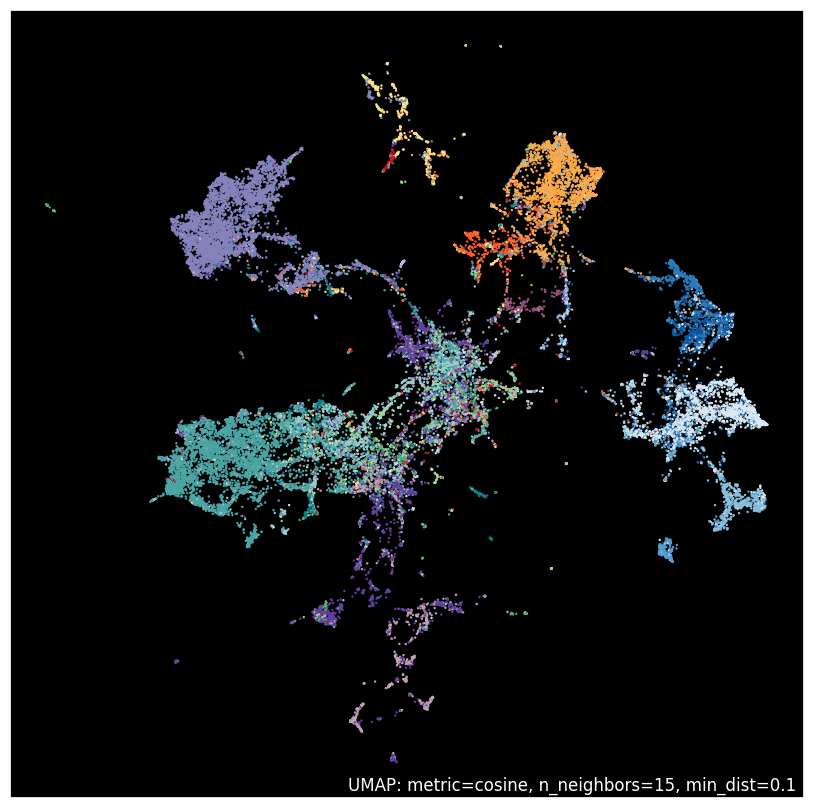

In [16]:
fig = plt.figure(figsize=(16, 16))
umap.plot.points(
    supervised_lat_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
    show_legend=False,
)
legend_elements = [
    matplotlib.patches.Patch(facecolor=color, label=label)
    for label, color in color_key.items()
]
fig.legend(legend_elements, color_key.keys(), loc="center right", bbox_to_anchor=(1.175, 0.5), borderaxespad=0.0)
# fig.tight_layout()
fig.savefig("figures/approximate_wasserstein.png", facecolor="none")

This is now looking remarkably good. The different newsgroups, which were already starting to separate have been mostly teased apart, and are starting to clump into distinct clusters. There are, of course, a number of outliers and patches where different newsgroups mix, but by and large this is an excellent result, both at the scale of individual newsgroups, and in the broader categories of newsgroup as seen via the custom colormap. 

## Qualitative comparison

Let's put all the different document embeddings we've produced here side-by-side so we can see them all at once. To make the comparison easier, we'll use a little Procrustes alignment to bring all the different UMAP embeddings into roughly the same position (UMAP is insensitive to rotations and reflections). Fortunately ``vectorizers`` has tools for this.

Next up is a big plotting cell to generate a grid of plots and then place all the different embeddings.

All of the vectorizers embeddings appear to be comparable to USE. Even the unsupervised feature weighting results in the left hand column are all excellent, with the raw feature reweighting as good or better than the BERT embedding, and the linear algebra and linear optimal transport based approaches looking as good or better than USE. These are excellent results for such a simple approach.

## Downstream Task Comparison

Given how good the qualitative comparison looks, it's worth checking some cold hard numbers. Especially to make sure that we haven't skewed things with the dimension reduction step. Let's see how the different embeddings fare at the downstream task of classifying the newsgroup posts.

In an ideal world a good document embedding should be good at this. We'll even branch out and try this over a variety of different sklearn classifiers as well (but mostly with default settings). This will not be a comprehensive benchmarking at downstream tasks (you should use something like SentEval for that), but rather a quick sketch to see roughly how these approaches compare in practice.

In [17]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

We'll also add TF-IDF and the raw information weighted matrices -- but use an SVD to get those down to 512 dimensions rather than the giant sparse matrices they are since the latter will break (or grind to a halt) some of our classifiers.

In [18]:
tfidf_doc_matrix = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(doc_matrix)
bow_512 = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=20).fit_transform(doc_matrix)
tfidf_512 = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=20).fit_transform(tfidf_doc_matrix)
info_512 = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=20).fit_transform(unsupervised_info_doc_matrix)
sinfo_512 = sklearn.decomposition.TruncatedSVD(n_components=60, n_iter=20).fit_transform(supervised_info_doc_matrix)

We are going to cut a few corners since this isn't a comprehensive benchmark (we want others to successfully run this example without taking forever). In particular, we are not going to repeatedly do a full test-train split,  and push only the training data all the way through all the transformations, and then evaluate on test. Instead we'll do a cross validation on the document embeddings we've already built.

This is cheating a little--our word embedding gets to see data in the test set, and our supervised information weighting is seeing label data from the test set. Thus, you should take these results with the requisite grains of salt.

With that said we have benchmarked all of these approaches properly with the full splits and processing and the results were largely the same. However, it does take an ungodly amount of time to run for 20 different splits. It is worth noting that BERT and USE have seen considerably more information for their (internal) word vectors, and USE has been trained on a wide variety of downstream tasks with label information.

In [19]:
def cross_validate(model, data, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, recipes_label, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, recipes_label, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        if np.mean(cv_scores) > 0.5:
            dfs.append(feature_df)
    return pd.concat(dfs)

Now we need a set of different models to try, and the different feature sets to use. First we'll try a `KNeighborsClassifier` since performing well with that classifier will mean that the document embedding is faithful at preserving neighborhoods. Then we'll try a couple of tree-based techniques with `HistGradientBoostingClassifier` and `RandomForestsClassifier`, and finally a quick `MLPClassifier` so we can say we used neural networks.

In [33]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets = {
    "Count": bow_512,
    "TF-IDF": tfidf_512,
    "InfoWeighted": info_512,
    "A-Wasserstein": lat_vectors_unsupervised,
    # "Supervised-A-Wasserstein": lat_vectors_supervised,
}

Now we reun the cross validation across all the models and all the feature sets. Be forewarned if you run this, it will take quite a while.

In [34]:
%%time
results = []
for model in models:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets,
        recipes_label,
    )
    results.append(res)

df_all = pd.concat( results )

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')
HistGradientBoostingClassifier()
RandomForestClassifier()
MLPClassifier(hidden_layer_sizes=(100, 80, 40))
CPU times: user 3d 7h 42s, sys: 3h 53min 33s, total: 3d 10h 54min 16s
Wall time: 7h 39min 37s


In [35]:
df = df_all

Finally we plot the results. We'll make some good use of seaborn to get a good looking comparison out.

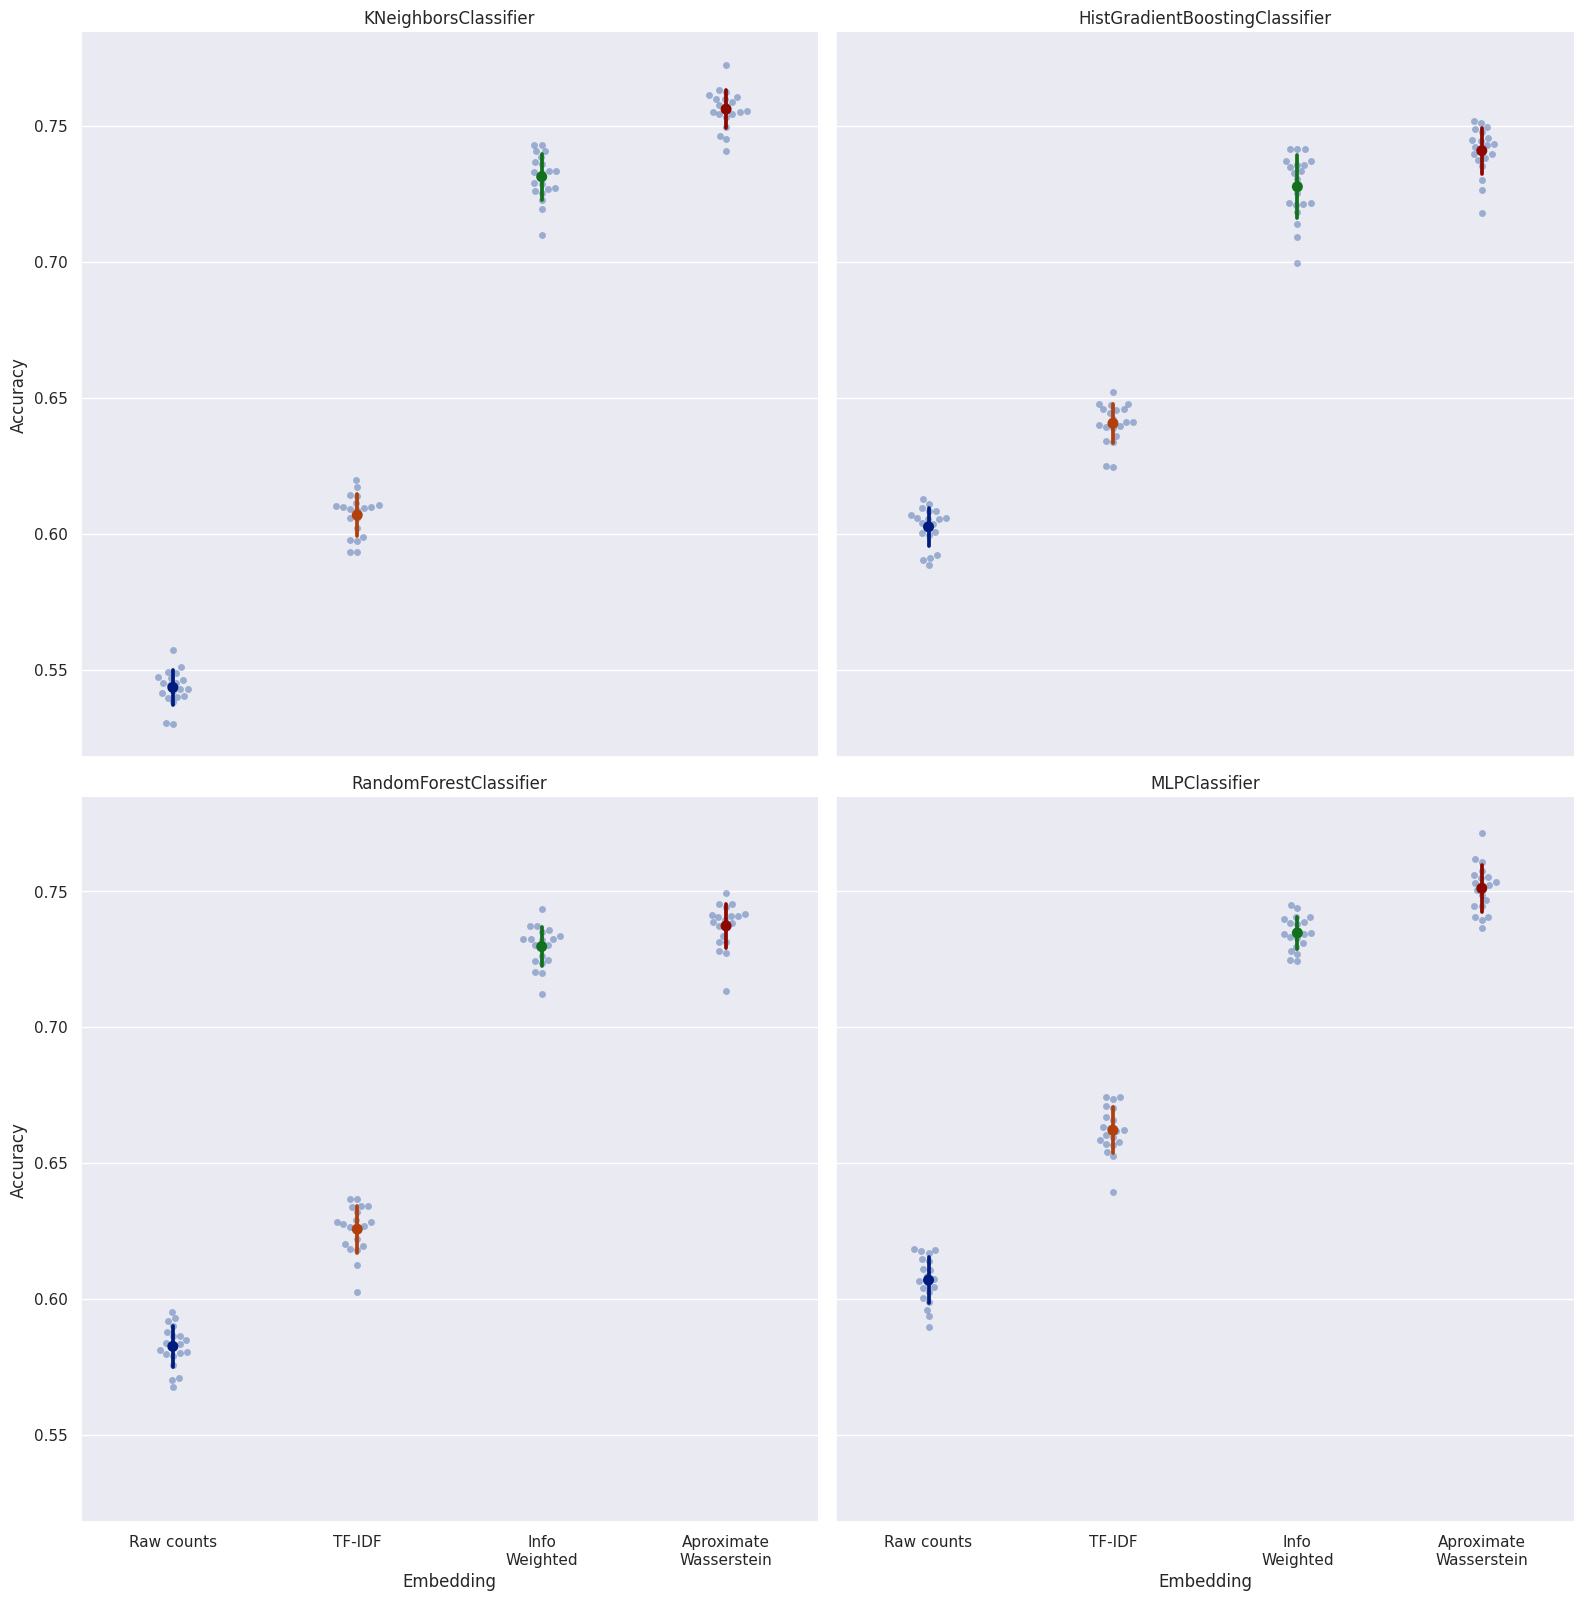

In [36]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df[df.Accuracy >= 0.5], 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df[df.Accuracy >= 0.5], 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Count",
        "TF-IDF", 
        "InfoWeighted", 
        "A-Wasserstein"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "Raw counts",
    "TF-IDF", 
    "Info\nWeighted", 
    "Aproximate\nWasserstein"
])
g.savefig("figures/recipe_embedding_comparison_downstream_task.png", facecolor="none")

In [ ]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df[df.Accuracy >= 0.5], 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df[df.Accuracy >= 0.5], 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Count",
        "TF-IDF", 
        "InfoWeighted", 
        "A-Wasserstein"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "Raw counts",
    "TF-IDF", 
    "Info\nWeighted", 
    "Aproximate\nWasserstein"
])
g.savefig("figures/recipe_embedding_comparison_downstream_task.png", facecolor="none")

And here are our quantitative results -- with appropriate caveats and salt grains. 

* **TF-IDF comparable to BERT**: The BERT based sentence embedder seems to perform surprisingly poorly in general on this dataset, regardless of the classifier used. In many cases it is quite comparable to straight-forward TF-IDF. Likely a better use of BERT than the out-of-the-box method we used here could provide better results. 
* **Information Weighting performs better than TF-IDF**: The other surprise is the information weighting. Theoretically, we would expect this to be roughly comparable to TF-IDF as it is a similar style of feature weighting. In practice, it seems to perform remarkably well under many of the classifiers, often scoring better than USE even in the unsupervised case. 
* **(Approximate) Wasserstein wins**: Finally both the linear algebra approximation and the optimal transport versions of the Wasserstein embedding perform well consistently across of all the classifiers. While the supervised case has an edge for some classifiers, the difference isn't that large, and even the unsupervised cases are consistently better performing than USE at this task on the 20 newsgroups dataset.